In [64]:
import requests as r
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
import pickle
import wikipedia
import matplotlib.pyplot as plt
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D

In [65]:
USE_PICKLED_DATA=True # Set false to get fresh data from the web, otherwise use the pickled data

# Obtaining the datasets from the web

## Scraping  `topuniversities.com`

In [66]:
URL = 'https://www.topuniversities.com'

In [67]:
data = r.get(URL + '/sites/default/files/qs-rankings-data/357051.txt').json()['data']

We want to filter by rank and extract the above properties. Some ranks are of the form: `X-Y` to indicate a range and some start with a `=` to indicate that two universities reached the same rank. As these formats complicate parsing, we first want to check whether the universities we interested in (the top 200) have their rank expressed in one of the two formats:

In [68]:
dash = set()
equals = set()
for uni in data:
    rank = uni['rank_display']
    if '-' in rank:
        dash.add(rank)
    if '=' in rank:
        equals.add(int(rank.lstrip('=')))

In [69]:
dash

{'401-410',
 '411-420',
 '421-430',
 '431-440',
 '441-450',
 '451-460',
 '461-470',
 '471-480',
 '481-490',
 '491-500',
 '501-550',
 '551-600',
 '601-650',
 '651-700',
 '701-750',
 '751-800',
 '801-1000'}

None of the intervals is relevant for our analysis

In [70]:
any(map(lambda v: v < 201, equals))

True

Some of the values starting with `=` are interesting for us.

In [71]:
fields = (
    'title',
    'country',
    'region',
    'url'
)

# Obtained by inspecting html source
to_scrape = (
    'total student',
    'total inter',
    'total faculty',
    'inter faculty'
)

In [72]:
if not USE_PICKLED_DATA:
    cleaned = []

    # As explained above, we are not interested in ranks with '-'
    for uni in filter(lambda u: '-' not in u['rank_display'], data):
        # parse rank
        rank = uni['rank_display']
        rank = np.uint32(rank.lstrip('='))

        # Only keep universities in top 200
        if rank < 201:
            # Retain important fields from ranking table
            clean_uni = {variable: uni[variable] for variable in fields}
            clean_uni['rank'] = rank

            cleaned.append(clean_uni)

            # Retrieve data from university page
            req = r.get(URL + uni['url'])
            soup = BeautifulSoup(req.text, 'html.parser')
            for field in to_scrape:
                div = soup.find('div', class_=field)
                if div:
                    clean_uni[field] = np.uint32(div.find('div', class_='number')\
                                                    .text.strip().replace(',', ''))
                else:
                    print('Could not find', field, 'for', uni['title'])

In [73]:
if not USE_PICKLED_DATA:
    # To work without having to pull everything down.
    with open('bcp.pickle', 'wb') as out:
        pickle.dump(cleaned, out)

In [74]:
with open('bcp.pickle', 'rb') as data_source:
    cleaned = pickle.load(data_source)

In [75]:
topuniversities = pd.DataFrame(cleaned)

In [76]:
topuniversities.head(10)

,country,inter faculty,rank,region,title,total faculty,total inter,total student,url
0,United States,1679.0,1,North America,Massachusetts Institute of Technology (MIT),2982.0,3717.0,11067.0,/universities/massachusetts-institute-technolo...
1,United States,2042.0,2,North America,Stanford University,4285.0,3611.0,15878.0,/universities/stanford-university
2,United States,1311.0,3,North America,Harvard University,4350.0,5266.0,22429.0,/universities/harvard-university
3,United States,350.0,4,North America,California Institute of Technology (Caltech),953.0,647.0,2255.0,/universities/california-institute-technology-...
4,United Kingdom,2278.0,5,Europe,University of Cambridge,5490.0,6699.0,18770.0,/universities/university-cambridge
5,United Kingdom,2964.0,6,Europe,University of Oxford,6750.0,7353.0,19720.0,/universities/university-oxford
6,United Kingdom,2554.0,7,Europe,UCL (University College London),6345.0,14854.0,31080.0,/universities/ucl-university-college-london
7,United Kingdom,2071.0,8,Europe,Imperial College London,3930.0,8746.0,16090.0,/universities/imperial-college-london
8,United States,635.0,9,North America,University of Chicago,2449.0,3379.0,13557.0,/universities/university-chicago
9,Switzerland,1886.0,10,Europe,ETH Zurich - Swiss Federal Institute of Techno...,2477.0,7563.0,19815.0,/universities/eth-zurich-swiss-federal-institu...


## Scraping `timeshighereducation.com`

In [77]:
URL = 'https://www.timeshighereducation.com'

In [78]:
data = r.get(URL + '/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json').json()['data']

In [79]:
dash = set()
equals = set()
plus = set()
for uni in data:
    rank = uni['rank']
    if '–' in rank:
        dash.add(rank)
    if '=' in rank:
        equals.add(int(rank.lstrip('=')))
    if '+' in rank:
        plus.add(rank)

In [80]:
dash

{'201–250',
 '251–300',
 '301–350',
 '351–400',
 '401–500',
 '501–600',
 '601–800',
 '801–1000'}

In [81]:
any(map(lambda v: v < 201, equals))

True

In [82]:
plus

{'1001+'}

In [83]:
def highereducation_university_builder(uni):
    intern_ratio = 0.01 * np.float32(uni['stats_pc_intl_students'].rstrip('%'))
    staff_ratio = np.float32(uni['stats_student_staff_ratio'])
    res = {
        'title': uni['name'],
        'country': uni['location'],
        'url': uni['url'],
        'total student': np.int32(uni['stats_number_students'].replace(',', ''))
    }
    # Having float number of person is not very relevent
    # Because of this we round the result to have an integer value
    res['total inter'] = np.round(intern_ratio * res['total student'])
    res['total faculty'] = np.round(res['total student'] / staff_ratio)
    return res

In [84]:
cleaned = []
region_not_found = []
for uni in filter(lambda u: all(map(lambda sym: sym not in u['rank'], ('–', '+'))), data):
    rank = uni['rank']
    rank = np.int32(rank.lstrip('='))
    if rank < 201:
        clean_uni = highereducation_university_builder(uni)
        clean_uni['rank'] = rank
        # To add region to clean_uni, we use the regions from topuniversities
        try:
            clean_uni['region'] = topuniversities[topuniversities['country'] == clean_uni['country']]['region'].iloc[0]
        except:
            print("Couldn't find region for uni {}".format(clean_uni['title']))
            region_not_found.append(clean_uni)
        cleaned.append(clean_uni)

Couldn't find region for uni University of Luxembourg
Couldn't find region for uni Lomonosov Moscow State University


In [85]:
highereducation = pd.DataFrame(cleaned)

We manually set the regions for the universities for which no region could be found. As there are only two of them, it is not a problem.

Moscow is considered to be on the European continent (https://en.wikipedia.org/wiki/Moscow)
Because of this we can use a loop to set the values

In [86]:
for not_found in region_not_found: 
    loc = highereducation['title'] == not_found['title']
    highereducation = highereducation.set_value(loc, 'region', 'Europe')

In [87]:
highereducation.head(10)

,country,rank,region,title,total faculty,total inter,total student,url
0,United Kingdom,1,Europe,University of Oxford,1822.0,7755.0,20409,/world-university-rankings/university-oxford
1,United Kingdom,2,Europe,University of Cambridge,1687.0,6436.0,18389,/world-university-rankings/university-cambridge
2,United States,3,North America,California Institute of Technology,340.0,596.0,2209,/world-university-rankings/california-institut...
3,United States,3,North America,Stanford University,2113.0,3486.0,15845,/world-university-rankings/stanford-university
4,United States,5,North America,Massachusetts Institute of Technology,1285.0,3800.0,11177,/world-university-rankings/massachusetts-insti...
5,United States,6,North America,Harvard University,2284.0,5285.0,20326,/world-university-rankings/harvard-university
6,United States,7,North America,Princeton University,958.0,1909.0,7955,/world-university-rankings/princeton-university
7,United Kingdom,8,Europe,Imperial College London,1391.0,8721.0,15857,/world-university-rankings/imperial-college-lo...
8,United States,9,North America,University of Chicago,2181.0,3381.0,13525,/world-university-rankings/university-chicago
9,Switzerland,10,Europe,ETH Zurich – Swiss Federal Institute of Techno...,1317.0,7309.0,19233,/world-university-rankings/eth-zurich-swiss-fe...


# Analysis of the university rankings

In this section, we will answer the following questions for both of the university rankings:

- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.


### Definition of usefull functions and tools for the analysis

In [88]:
# Spice up our print display
# Taken from https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Example:
print(color.BOLD + 'Hello World !' + color.END)

END_STR = color.END
BU_STR  = color.BOLD+color.UNDERLINE

Hello World !


In [89]:
# Lets define a useful order of columns that we find meaningful:
TOP_UNI_BASE_COL = ["rank", "country", "region", "title"]
FAC_STUD_RATIO_COL = ["total faculty", "total student", "faculty student ratio"]
INTER_STUD_RATIO_COL = ["total inter", "total student", "inter student ratio"]

** We define to usefull functions to do the sorting by ratio for us and print the results **

In [90]:
def ratio_analysis_per_school(uni_df, nbest=10):
    """
    This function takes a dataframe and will analyse the ratio of facutly
    member to student as well as the ratio of internatioal students to students.
    It will do so for each schools it contains
    It will print the result in a nicely formatted way
    
    Keywords:
    university_df -- DataFrame containing the university data
    """
    uni_df["faculty student ratio"] = uni_df["total faculty"] / uni_df["total student"]
    uni_df["inter student ratio"]   = uni_df["total inter"] / uni_df["total student"]

    best_fac_stu = uni_df[['title', 'faculty student ratio']].sort_values("faculty student ratio", ascending=False)\
                                                             .head(nbest)
        
    best_inter_stu = uni_df[['title', 'inter student ratio']].sort_values("inter student ratio", ascending=False)\
                                                             .head(nbest)
    
    # In the display, only output meaningful information regarding to the filter at hand
    print(BU_STR + "Dataframe with ratios" + END_STR)
    display(uni_df.head(nbest))

    print(BU_STR + "Schools sorted by their faculty to student ratio" + END_STR)
    display(best_fac_stu)
    
    print(BU_STR + "Schools sorted by their international student ratio" + END_STR)
    display(best_inter_stu)
            
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,20))
    
    best_fac_stu = best_fac_stu[::-1]
    best_fac_stu.plot(kind='barh', ax=ax1)
    ax1.set_yticklabels(best_fac_stu['title'], fontsize=15)
    ax1.set_title('Top 10 universities by faculty/students ratio', fontsize=20)
    
    best_inter_stu = best_inter_stu[::-1]
    best_inter_stu.plot(kind='barh', ax=ax2)
    ax2.set_yticklabels(best_inter_stu['title'], fontsize=15)
    ax2.set_title('Top 10 universities by international students ratio', fontsize=20)
    
    plt.show()

In [91]:
def ratio_analysis_per_column(uni_df, column_name, nbest=10):
    """
    This function takes a dataframe and will analyse the ratio of facutly
    member to student as well as the ratio of international students to total students.
    It will do so by aggregating the elements sharing the same value in the column_name column.
    It will print the result in a nicely formatted way
    
    Keywords:
    university_df -- DataFrame containing the university data
    column_name   -- Name of the column for which the values of same-name entry will be aggregated
    """
    
    # The metodology used in this answer comes from: https://stackoverflow.com/questions/35307732/how-to-sum-in-pandas-by-unique-index-in-several-columns   
    uni_df_country = uni_df.groupby(column_name)["total inter", "total student", "total faculty"]\
                           .sum()\
                           .reset_index()
    uni_df_country["faculty student ratio"] = uni_df_country["total faculty"] / uni_df_country["total student"]
    uni_df_country["inter student ratio"]   = uni_df_country["total inter"] / uni_df_country["total student"]

    fac_stud = uni_df_country[[column_name, 'faculty student ratio']]\
                             .sort_values("faculty student ratio", ascending=False)\
                             .head(nbest)
    
    inter = uni_df_country[[column_name, 'inter student ratio']]\
                          .sort_values("inter student ratio", ascending=False)\
                          .head(nbest)
            
    # Display the results            
    print(BU_STR + "Resulting dataframe sorted by {}".format(column_name) + END_STR)
    display(uni_df_country.head(nbest))
    
    print(BU_STR + "{} sorted by their faculty to student ratio".format(column_name) + END_STR)
    display(fac_stud)

    print(BU_STR + "{} sorted by their international student ratio".format(column_name) + END_STR)
    display(inter)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    
    fac_stud = fac_stud[::-1]
    fac_stud['faculty student ratio'].plot(kind='barh', ax=ax1)
    ax1.set_yticklabels(fac_stud[column_name], fontsize=15)
    ax1.set_title('Faculty to student ratios', fontsize=20)
    
    inter = inter[::-1]
    inter['inter student ratio'].plot(kind='barh', ax=ax2)
    ax2.set_yticklabels(inter[column_name], fontsize=15)
    ax2.set_title('International student ratios', fontsize=20)
    plt.show()   

### Analysis of ratios for the website topuniversities.com

Analysis of faculty to student ratio and international student ratio per school

Dataframe with ratios


,country,inter faculty,rank,region,title,total faculty,total inter,total student,url,faculty student ratio,inter student ratio
0,United States,1679.0,1,North America,Massachusetts Institute of Technology (MIT),2982.0,3717.0,11067.0,/universities/massachusetts-institute-technolo...,0.269450,0.335863
1,United States,2042.0,2,North America,Stanford University,4285.0,3611.0,15878.0,/universities/stanford-university,0.269870,0.227422
2,United States,1311.0,3,North America,Harvard University,4350.0,5266.0,22429.0,/universities/harvard-university,0.193945,0.234785
3,United States,350.0,4,North America,California Institute of Technology (Caltech),953.0,647.0,2255.0,/universities/california-institute-technology-...,0.422616,0.286918
4,United Kingdom,2278.0,5,Europe,University of Cambridge,5490.0,6699.0,18770.0,/universities/university-cambridge,0.292488,0.356899
5,United Kingdom,2964.0,6,Europe,University of Oxford,6750.0,7353.0,19720.0,/universities/university-oxford,0.342292,0.372870
6,United Kingdom,2554.0,7,Europe,UCL (University College London),6345.0,14854.0,31080.0,/universities/ucl-university-college-london,0.204151,0.477928
7,United Kingdom,2071.0,8,Europe,Imperial College London,3930.0,8746.0,16090.0,/universities/imperial-college-london,0.244251,0.543567
8,United States,635.0,9,North America,University of Chicago,2449.0,3379.0,13557.0,/universities/university-chicago,0.180645,0.249244
9,Switzerland,1886.0,10,Europe,ETH Zurich - Swiss Federal Institute of Techno...,2477.0,7563.0,19815.0,/universities/eth-zurich-swiss-federal-institu...,0.125006,0.381681


Schools sorted by their faculty to student ratio


,title,faculty student ratio
3,California Institute of Technology (Caltech),0.422616
15,Yale University,0.398323
5,University of Oxford,0.342292
4,University of Cambridge,0.292488
16,Johns Hopkins University,0.276353
1,Stanford University,0.269870
0,Massachusetts Institute of Technology (MIT),0.269450
185,University of Rochester,0.266604
18,University of Pennsylvania,0.266437
17,Columbia University,0.247115


Schools sorted by their international student ratio


,title,inter student ratio
34,London School of Economics and Political Scien...,0.691393
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047
7,Imperial College London,0.543567
198,Maastricht University,0.502533
47,Carnegie Mellon University,0.478062
6,UCL (University College London),0.477928
91,University of St Andrews,0.457955
41,The University of Melbourne,0.427434
126,Queen Mary University of London,0.421816
25,The University of Hong Kong,0.407144


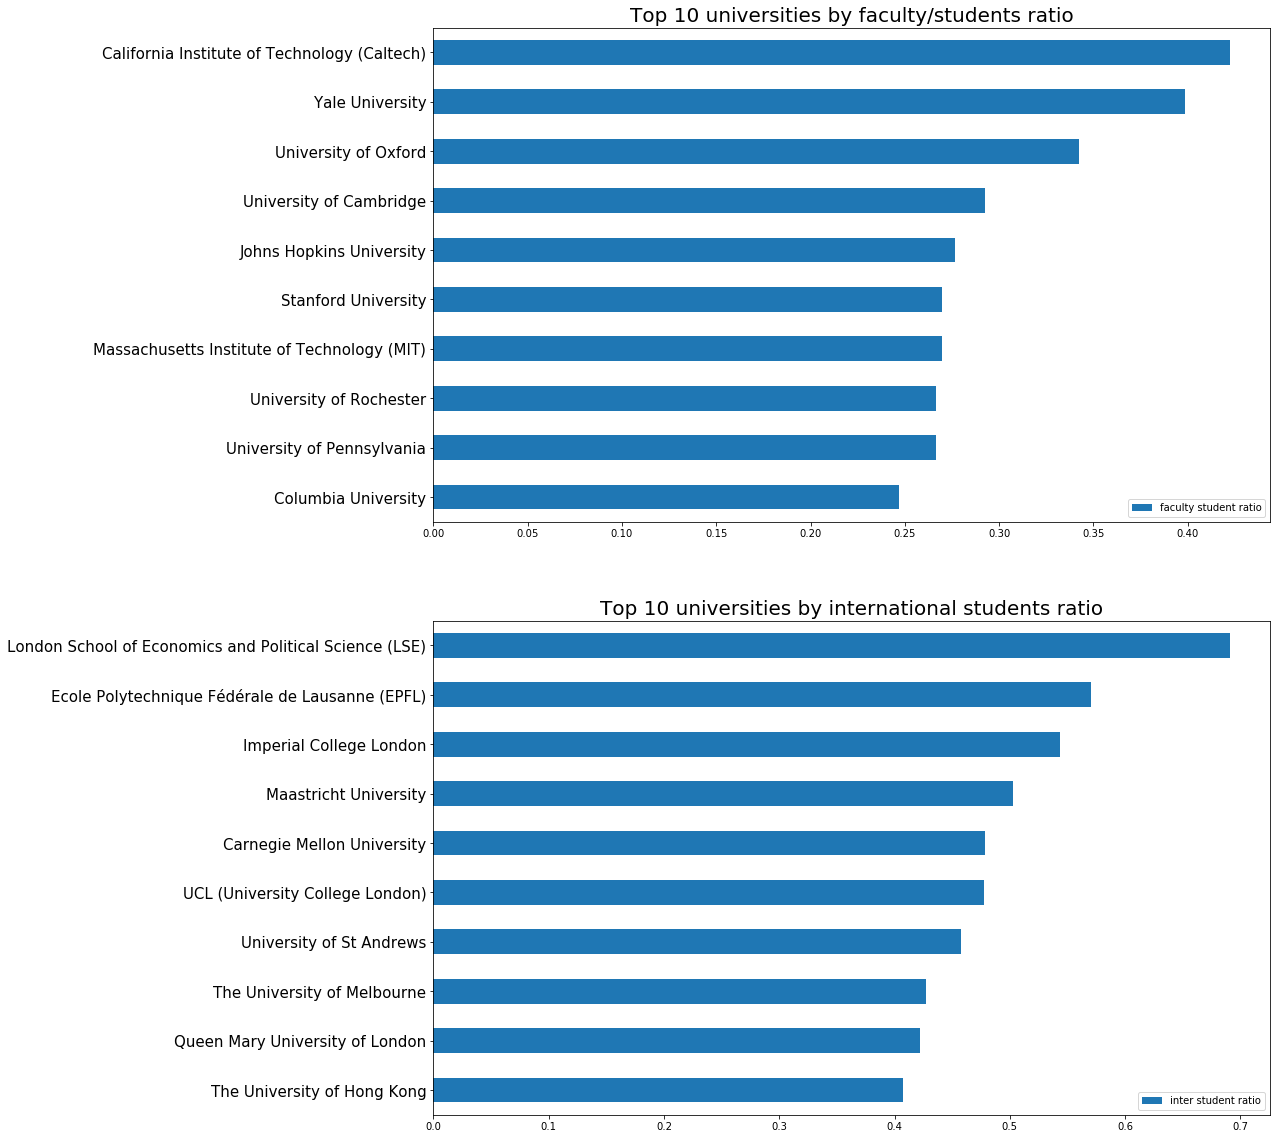

In [92]:
print(BU_STR + color.BLUE+"Analysis of faculty to student ratio and international student ratio per school\n" + END_STR)
ratio_analysis_per_school(topuniversities)

We observe that Caltech, Yale and Oxford dominate according to the faculty/students ratio while for the proportion of international students we have different schools: LSE, EPFL and Imperial College are the best.

Analysis of faculty to student ratio and international student ratio per country

Resulting dataframe sorted by country


,country,total inter,total student,total faculty,faculty student ratio,inter student ratio
0,Argentina,27109.0,122301.0,16421.0,0.134267,0.221658
1,Australia,106359.0,301994.0,22034.0,0.072962,0.352189
2,Austria,19667.0,63446.0,4117.0,0.064890,0.309980
3,Belgium,17013.0,115067.0,8046.0,0.069924,0.147853
4,Brazil,3052.0,92283.0,7550.0,0.081814,0.033072
5,Canada,73239.0,281514.0,29317.0,0.104140,0.260161
6,Chile,991.0,27003.0,2260.0,0.083694,0.036700
7,China,26833.0,235898.0,27220.0,0.115389,0.113748
8,Denmark,9543.0,67223.0,11916.0,0.177261,0.141960
9,Finland,3065.0,34566.0,3902.0,0.112885,0.088671


country sorted by their faculty to student ratio


,country,faculty student ratio
23,Russia,0.221910
8,Denmark,0.177261
24,Saudi Arabia,0.175828
25,Singapore,0.161530
18,Malaysia,0.153893
17,Japan,0.152479
27,South Korea,0.141721
30,Switzerland,0.140434
32,United Kingdom,0.136962
15,Israel,0.136047


country sorted by their international student ratio


,country,inter student ratio
1,Australia,0.352189
32,United Kingdom,0.341705
12,Hong Kong,0.310751
2,Austria,0.309980
30,Switzerland,0.302396
25,Singapore,0.276537
5,Canada,0.260161
21,New Zealand,0.258215
14,Ireland,0.235299
20,Netherlands,0.232980


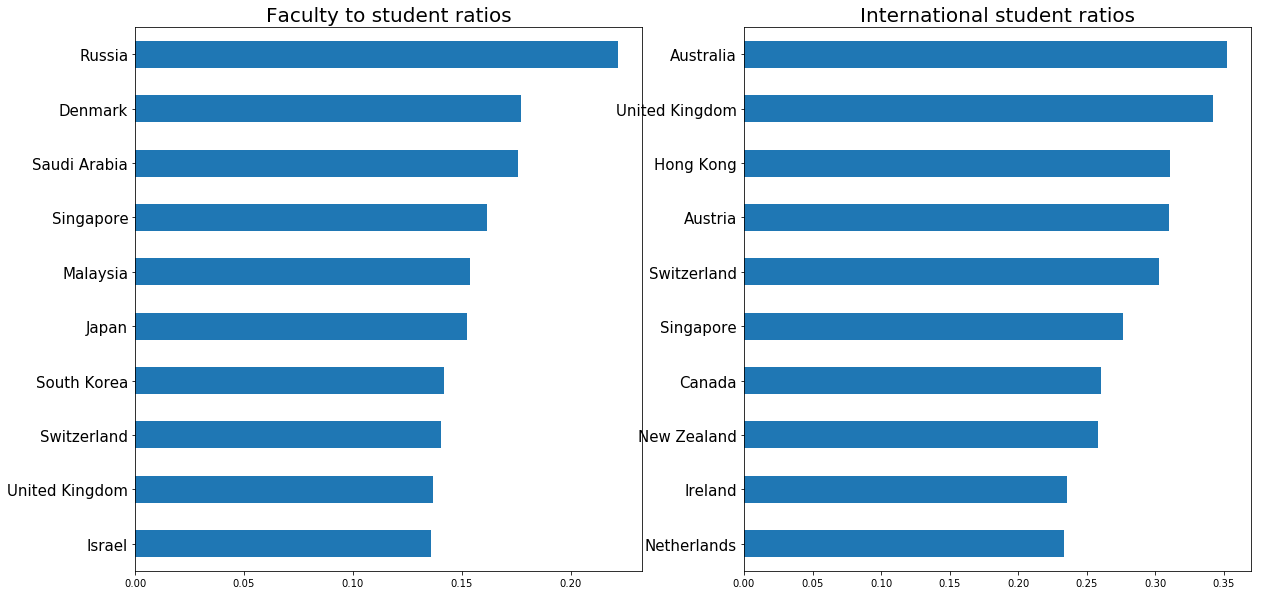

In [93]:
print(BU_STR+color.BLUE+"Analysis of faculty to student ratio and international student ratio per country\n"+END_STR)
ratio_analysis_per_column(topuniversities, "country")

This time we aggregated the data by country and some surprises occur: Russia, Denmark and Saudia Arabia have the highest ratios of faculty/students. The highest ratios of international students are found in Australia and in the UK.

Analysis of faculty to student ratio and international student ratio per region

Resulting dataframe sorted by region


,region,total inter,total student,total faculty,faculty student ratio,inter student ratio
0,Africa,3325.0,19593.0,1733.0,0.088450,0.169703
1,Asia,110100.0,807003.0,106734.0,0.132260,0.136431
2,Europe,449364.0,1957251.0,218358.0,0.111564,0.229589
3,Latin America,34737.0,396902.0,43126.0,0.108657,0.087520
4,North America,292116.0,1546353.0,182123.0,0.117776,0.188906
5,Oceania,118798.0,350167.0,25347.0,0.072385,0.339261


region sorted by their faculty to student ratio


,region,faculty student ratio
1,Asia,0.132260
4,North America,0.117776
2,Europe,0.111564
3,Latin America,0.108657
0,Africa,0.088450
5,Oceania,0.072385


region sorted by their international student ratio


,region,inter student ratio
5,Oceania,0.339261
2,Europe,0.229589
4,North America,0.188906
0,Africa,0.169703
1,Asia,0.136431
3,Latin America,0.087520


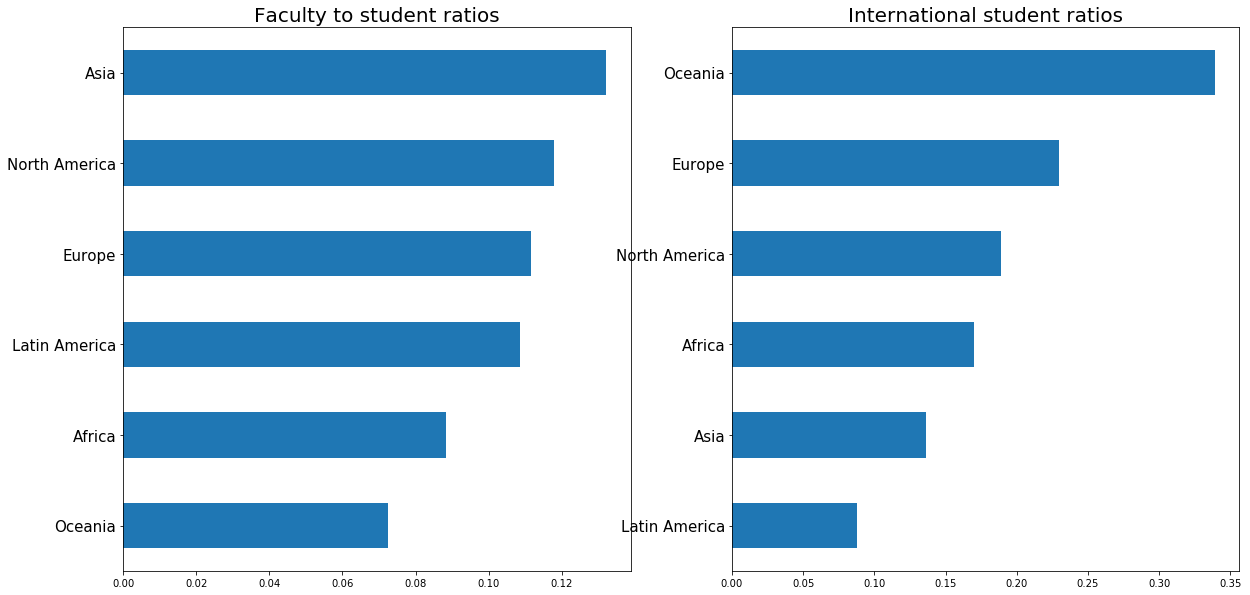

In [94]:
print(BU_STR+color.BLUE+"Analysis of faculty to student ratio and international student ratio per region\n"+END_STR)
ratio_analysis_per_column(topuniversities, "region")

Zooming out once more, we look at continents, remarking that Asia and North America have the highest ratios of faculty/students while Oceania dominates with its ratio of international students.

### Analysis of ratios for the website timeshighereducation.com

Analysis of faculty to student ratio and international student ratio per school

Dataframe with ratios


,country,rank,region,title,total faculty,total inter,total student,url,faculty student ratio,inter student ratio
0,United Kingdom,1,Europe,University of Oxford,1822.0,7755.0,20409,/world-university-rankings/university-oxford,0.089274,0.379979
1,United Kingdom,2,Europe,University of Cambridge,1687.0,6436.0,18389,/world-university-rankings/university-cambridge,0.091740,0.349992
2,United States,3,North America,California Institute of Technology,340.0,596.0,2209,/world-university-rankings/california-institut...,0.153916,0.269805
3,United States,3,North America,Stanford University,2113.0,3486.0,15845,/world-university-rankings/stanford-university,0.133354,0.220006
4,United States,5,North America,Massachusetts Institute of Technology,1285.0,3800.0,11177,/world-university-rankings/massachusetts-insti...,0.114968,0.339984
5,United States,6,North America,Harvard University,2284.0,5285.0,20326,/world-university-rankings/harvard-university,0.112368,0.260012
6,United States,7,North America,Princeton University,958.0,1909.0,7955,/world-university-rankings/princeton-university,0.120427,0.239975
7,United Kingdom,8,Europe,Imperial College London,1391.0,8721.0,15857,/world-university-rankings/imperial-college-lo...,0.087722,0.549978
8,United States,9,North America,University of Chicago,2181.0,3381.0,13525,/world-university-rankings/university-chicago,0.161257,0.249982
9,Switzerland,10,Europe,ETH Zurich – Swiss Federal Institute of Techno...,1317.0,7309.0,19233,/world-university-rankings/eth-zurich-swiss-fe...,0.068476,0.380024


Schools sorted by their faculty to student ratio


,title,faculty student ratio
105,Vanderbilt University,0.303056
109,University of Copenhagen,0.243889
11,Yale University,0.232579
153,University of Rochester,0.232565
12,Johns Hopkins University,0.232546
97,Emory University,0.227291
16,Duke University,0.222208
114,École Polytechnique,0.196141
183,Scuola Normale Superiore di Pisa,0.192233
101,University of Pittsburgh,0.169492


Schools sorted by their international student ratio


,title,inter student ratio
24,London School of Economics and Political Science,0.709985
178,University of Luxembourg,0.569934
7,Imperial College London,0.549978
37,École Polytechnique Fédérale de Lausanne,0.549960
102,Maastricht University,0.500030
15,University College London,0.490001
143,University of St Andrews,0.479956
23,Carnegie Mellon University,0.449984
120,Queen Mary University of London,0.449984
39,University of Hong Kong,0.420007


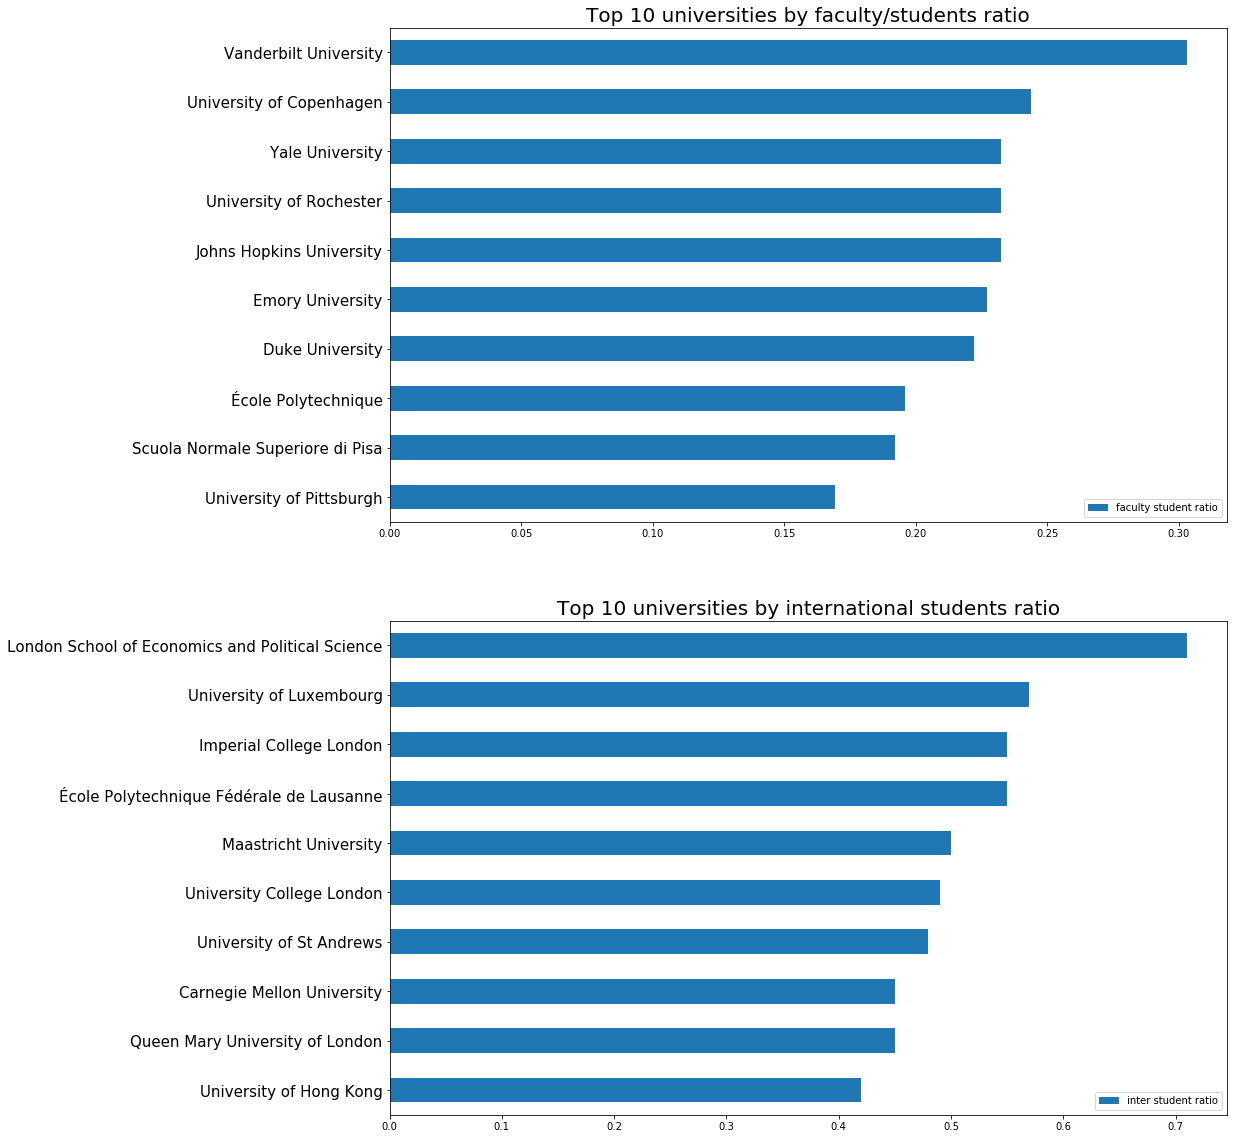

In [95]:
print(BU_STR+color.BLUE+"Analysis of faculty to student ratio and international student ratio per school\n"+END_STR)
ratio_analysis_per_school(highereducation)

The data obtained from this second website provides us with slightly different conclusions Vanderbuilt University and the University of Copenhagen are the best in terms of faculty to student ratio while LSE and the University of Luxembourg score the highest in proportion of international students.

Analysis of faculty to student ratio and international student ratio per country

Resulting dataframe sorted by country


,country,total inter,total student,total faculty,faculty student ratio,inter student ratio
0,Australia,83812.0,268630,9940.0,0.037003,0.311998
1,Austria,9198.0,35375,1701.0,0.048085,0.260014
2,Belgium,23769.0,130115,3428.0,0.026346,0.182677
3,Canada,55906.0,249401,13240.0,0.053087,0.224161
4,China,22883.0,253911,21390.0,0.084242,0.090122
5,Denmark,9327.0,64110,10598.0,0.165310,0.145484
6,Finland,3901.0,35276,2022.0,0.057319,0.110585
7,France,18975.0,99378,7437.0,0.074835,0.190938
8,Germany,87490.0,586364,15355.0,0.026187,0.149208
9,Hong Kong,25158.0,77663,4141.0,0.053320,0.323938


country sorted by their faculty to student ratio


,country,faculty student ratio
5,Denmark,0.165310
17,Russian Federation,0.136989
12,Japan,0.133351
11,Italy,0.131120
23,Switzerland,0.093174
26,United States,0.089329
24,Taiwan,0.086970
19,South Africa,0.085487
4,China,0.084242
7,France,0.074835


country sorted by their international student ratio


,country,inter student ratio
13,Luxembourg,0.569934
25,United Kingdom,0.357211
9,Hong Kong,0.323938
0,Australia,0.311998
18,Singapore,0.304558
23,Switzerland,0.303620
15,New Zealand,0.290003
10,Ireland,0.269976
1,Austria,0.260014
3,Canada,0.224161


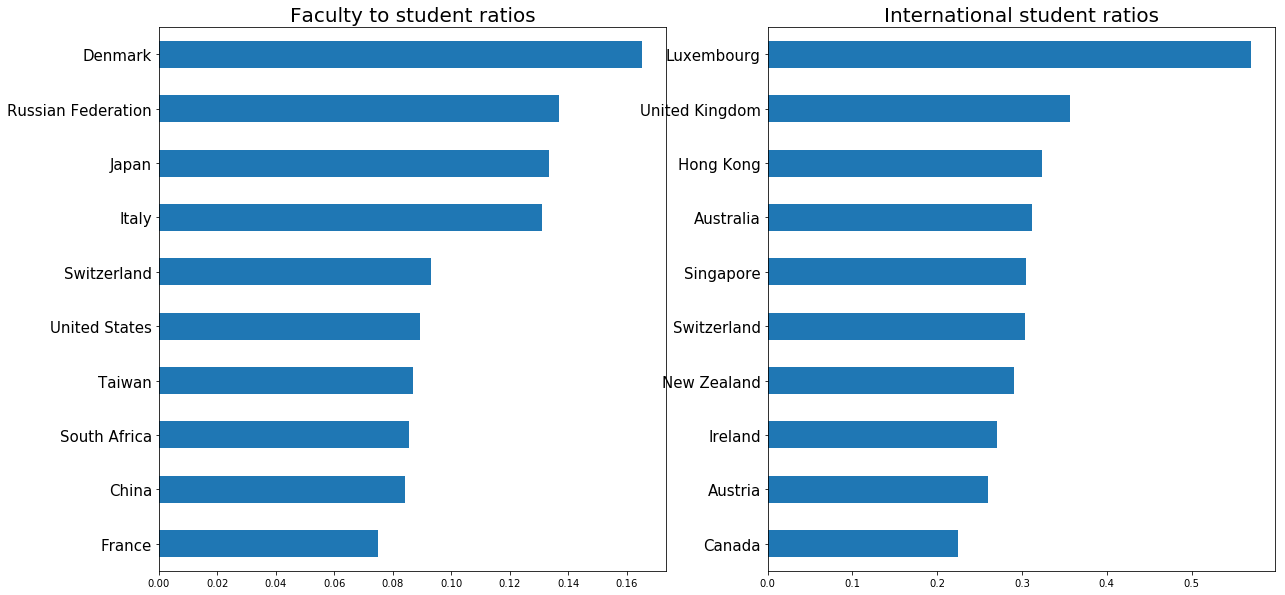

In [96]:
print(BU_STR+color.BLUE+"Analysis of faculty to student ratio and international student ratio per country\n"+END_STR)
ratio_analysis_per_column(highereducation, "country")

Comparing countrywise, the top three are very similar to the ranking obtained from the data of the previous website.

Analysis of faculty to student ratio and international student ratio per region

Resulting dataframe sorted by region


,region,total inter,total student,total faculty,faculty student ratio,inter student ratio
0,Africa,3740.0,20775,1776.0,0.085487,0.180024
1,Asia,78839.0,530949,42636.0,0.080301,0.148487
2,Europe,481576.0,2143623,126864.0,0.059182,0.224655
3,North America,336271.0,1954934,165594.0,0.084706,0.172011
4,Oceania,92613.0,298978,11554.0,0.038645,0.309765


region sorted by their faculty to student ratio


,region,faculty student ratio
0,Africa,0.085487
3,North America,0.084706
1,Asia,0.080301
2,Europe,0.059182
4,Oceania,0.038645


region sorted by their international student ratio


,region,inter student ratio
4,Oceania,0.309765
2,Europe,0.224655
0,Africa,0.180024
3,North America,0.172011
1,Asia,0.148487


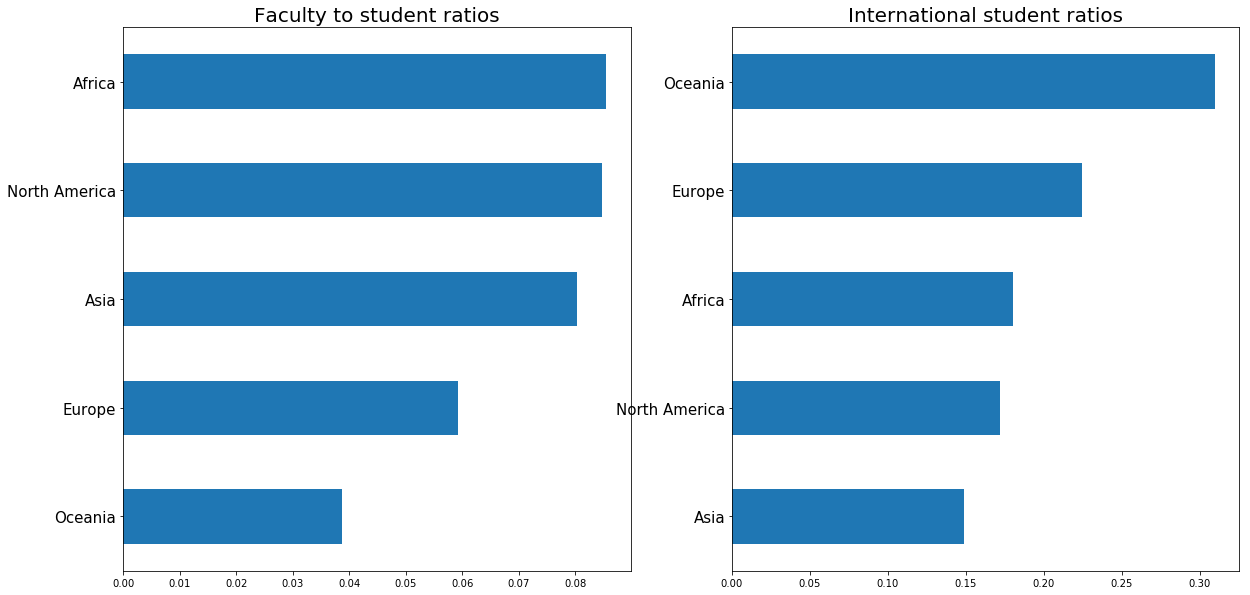

In [97]:
print(BU_STR+color.BLUE+"Analysis of faculty to student ratio and international student ratio per region\n"+END_STR)
ratio_analysis_per_column(highereducation, "region")

The ranking here sees more slight variations, with Asia becoming third for the ratio faculty/students after Africa and north America. The ranking based on the proportion of international students is consistent with the one obtained from data from Topuniversities.com

# Combined analysis of the university rankings

## Merging the two resulting DataFrames

We now want to merge the to dataframes we obtained into a single one, by using the name of the university as a reference point.  
We also want to keep the rank of each university in both website as a separate column in the resulting dataframe.


In [98]:
topuniversities.head(1)

,country,inter faculty,rank,region,title,total faculty,total inter,total student,url,faculty student ratio,inter student ratio
0,United States,1679.0,1,North America,Massachusetts Institute of Technology (MIT),2982.0,3717.0,11067.0,/universities/massachusetts-institute-technolo...,0.26945,0.335863


In [99]:
highereducation.head(1)

,country,rank,region,title,total faculty,total inter,total student,url,faculty student ratio,inter student ratio
0,United Kingdom,1,Europe,University of Oxford,1822.0,7755.0,20409,/world-university-rankings/university-oxford,0.089274,0.379979


In [100]:
def compare_uni_titles(df1, df2):
    """
    This function goes through the titles of the university in a ranking dataframe and print
    the name of the university that have not been found in the other.
    It should only be used as an indicator: some names might not be shared from one ranking to the other
    """
    for title in df1["title"]:
        #print(title)
        index = pd.Series([item == -1 for item in df2["title"].str.find(title)])
        if index.all():  
            print("Not found:", title)
    print("---------------------------------------------------------------------------------------------")
    for title in df2["title"]:
        #print(title)
        index = pd.Series([item == -1 for item in df1["title"].str.find(title)])
        if index.all():  
            print("Not found:", title)

In [101]:
# Universities in topuniversities contain their acronyme, we want to remove it
compare_uni_titles(highereducation, topuniversities)

Not found: ETH Zurich – Swiss Federal Institute of Technology Zurich
Not found: LMU Munich
Not found: King’s College London
Not found: École Polytechnique Fédérale de Lausanne
Not found: Karolinska Institute
Not found: Heidelberg University
Not found: Washington University in St Louis
Not found: University of North Carolina at Chapel Hill
Not found: Humboldt University of Berlin
Not found: Wageningen University & Research
Not found: Paris Sciences et Lettres – PSL Research University Paris
Not found: University of Freiburg
Not found: Free University of Berlin
Not found: Technical University of Berlin
Not found: University of Tübingen
Not found: Korea Advanced Institute of Science and Technology (KAIST)
Not found: University of Bonn
Not found: Vanderbilt University
Not found: University of Montreal
Not found: École Polytechnique
Not found: Indiana University
Not found: Radboud University Nijmegen
Not found: Georgetown University
Not found: Pierre and Marie Curie University
Not found: Un

The result above are very troublesome: some university names are not written in English!
Also, there's non-standard variation in the university names, would be hard to parse with regex!

We look fo the name of the university on wikipedia and use the first result to obtain the actual title of the university

In [102]:
def get_uni_name_from_wikipedia(name_in_df):
    """Search for the University on Wikipedia and return its name"""
    wiki_page = wikipedia.page(wikipedia.search(name_in_df)[0])
    return wiki_page.title

In [103]:
if not USE_PICKLED_DATA:
    topuniversities_good_name = topuniversities
    for row in topuniversities_good_name.itertuples():
        proper_name = get_uni_name_from_wikipedia(row.title)
        topuniversities_good_name.set_value(row.Index, "title", proper_name)

    # To work without having to pull everything down.
    with open('top_uni_good_name.pickle', 'wb') as out:
        pickle.dump(topuniversities_good_name, out)

In [104]:
with open('top_uni_good_name.pickle', 'rb') as data_source:
    topuniversities_good_name = pickle.load(data_source)

In [105]:
if not USE_PICKLED_DATA:
    highereducation_good_name = highereducation
    for row in highereducation_good_name.itertuples():
        proper_name = get_uni_name_from_wikipedia(row.title)
        highereducation_good_name.set_value(row.Index, "title", proper_name)

    # To work without having to pull everything down.
    with open('higher_ed_good_name.pickle', 'wb') as out:
        pickle.dump(highereducation_good_name, out)

In [106]:
with open('higher_ed_good_name.pickle', 'rb') as data_source:
    highereducation_good_name = pickle.load(data_source)

In [107]:
compare_uni_titles(topuniversities_good_name, highereducation_good_name)

Not found: UCLA School of Law
Not found: École Normale Supérieure
Not found: New York University School of Law
Not found: Tokyo Institute of Technology
Not found: Osaka University
Not found: University of Buenos Aires
Not found: Tohoku University
Not found: Korea University
Not found: Yonsei University
Not found: University of Malaya
Not found: Nagoya University
Not found: University of São Paulo
Not found: National Autonomous University of Mexico
Not found: Hokkaido University
Not found: Kyushu University
Not found: Chalmers University of Technology
Not found: Pontifical Catholic University of Chile
Not found: Hebrew University of Jerusalem
Not found: University of Otago
Not found: University of Waterloo
Not found: Hanyang University
Not found: University of Bath
Not found: National Tsing Hua University
Not found: University of Bergen
Not found: University College Dublin
Not found: Polytechnic University of Milan
Not found: Indian Institute of Technology Delhi
Not found: King Fahd Uni

There's still universities that are not shared between the two list, but it looks as it is not caused by 
an error in naming, but because they are effectively not in the other list. We will accept this result and proceed with the merge of the Dataframes.

In [108]:
topuniversities_good_name.columns

Index(['country', 'inter faculty', 'rank', 'region', 'title', 'total faculty',
       'total inter', 'total student', 'url', 'faculty student ratio',
       'inter student ratio'],
      dtype='object')

In [109]:
# Clean up the dataframe for the merge
# Drop the url, not meaningfull anymore
# We use try in case it was already deleted
topuniversities_good_name.drop("url", axis=1, inplace=True)
highereducation_good_name.drop("url", axis=1, inplace=True)

# Drop the inter faculty from topuniversity, we don't have the info in
# the other dataframe so its meaningless in the future

topuniversities_good_name.drop("inter faculty", axis=1, inplace=True)

# Change the column names so its not automatic
topuniversities_good_name.rename(columns={
    "rank": "tu rank",
    "total faculty": "tu total faculty",
    "total inter": "tu total inter",
    "total student": "tu total student",
    "inter faculty": "tu inter faculty"
}, inplace=True)

highereducation_good_name.rename(columns={
    "rank": "he rank",
    "total faculty": "he total faculty",
    "total inter": "he total inter",
    "total student": "he total student"
}, inplace=True)

# Merge
merged_rankings = pd.merge(topuniversities_good_name, highereducation_good_name,
                           how='outer', on=["title", "country", "region"] )
merged_rankings.head(10)

,country,tu rank,region,title,tu total faculty,tu total inter,tu total student,faculty student ratio_x,inter student ratio_x,he rank,he total faculty,he total inter,he total student,faculty student ratio_y,inter student ratio_y
0,United States,1.0,North America,Massachusetts Institute of Technology,2982.0,3717.0,11067.0,0.269450,0.335863,5.0,1285.0,3800.0,11177.0,0.114968,0.339984
1,United States,2.0,North America,Stanford University,4285.0,3611.0,15878.0,0.269870,0.227422,3.0,2113.0,3486.0,15845.0,0.133354,0.220006
2,United States,3.0,North America,Harvard University,4350.0,5266.0,22429.0,0.193945,0.234785,6.0,2284.0,5285.0,20326.0,0.112368,0.260012
3,United States,4.0,North America,California Institute of Technology,953.0,647.0,2255.0,0.422616,0.286918,3.0,340.0,596.0,2209.0,0.153916,0.269805
4,United Kingdom,5.0,Europe,University of Cambridge,5490.0,6699.0,18770.0,0.292488,0.356899,2.0,1687.0,6436.0,18389.0,0.091740,0.349992
5,United Kingdom,6.0,Europe,University of Oxford,6750.0,7353.0,19720.0,0.342292,0.372870,1.0,1822.0,7755.0,20409.0,0.089274,0.379979
6,United Kingdom,7.0,Europe,University College London,6345.0,14854.0,31080.0,0.204151,0.477928,16.0,2886.0,14849.0,30304.0,0.095235,0.490001
7,United Kingdom,8.0,Europe,Imperial College London,3930.0,8746.0,16090.0,0.244251,0.543567,8.0,1391.0,8721.0,15857.0,0.087722,0.549978
8,United States,9.0,North America,University of Chicago,2449.0,3379.0,13557.0,0.180645,0.249244,9.0,2181.0,3381.0,13525.0,0.161257,0.249982
9,Switzerland,10.0,Europe,ETH Zurich,2477.0,7563.0,19815.0,0.125006,0.381681,10.0,1317.0,7309.0,19233.0,0.068476,0.380024


In [110]:
# Lets manage the column names
new_cols=['region', 'country', 'title',
          'tu rank', 'tu total faculty', 'tu total inter', 'tu total student',
          'he rank', 'he total faculty', 'he total inter', 'he total student']
merged_rankings = merged_rankings[new_cols]

In [112]:
# Generate a new DataFrame with better labels for columns
col_name_per_ranking = ['rank', 'total faculty', 'total inter', 'total student']

first_column = ["University Info", "University Info", "University Info",
                "Top Universities", "Top Universities", "Top Universities", "Top Universities", "Top Universities",
                "Higher Education", "Higher Education", "Higher Education", "Higher Education"]

second_column = ["region", "country", "title"] + col_name_per_ranking + ["inter faculty"] + col_name_per_ranking

merged_rankings = pd.DataFrame(data=merged_rankings.values,
                               index=merged_rankings.index,
                               columns=[first_column, second_column])

ValueError: Shape of passed values is (11, 244), indices imply (12, 244)

In [ ]:
merged_rankings.head(10)

## Analysing the resulting data

In [ ]:
# Add average column
ranking_with_avg = merged_rankings
for col in col_name_per_ranking:
    ranking_with_avg["Average", col] = ranking_with_avg[[("Top Universities", col), ("Higher Education", col)]]\
                                                       .mean(axis=1)

In [ ]:
# Add metrics to the average measurement
ranking_with_metrics = ranking_with_avg
ranking_with_metrics["Metrics", "faculty student ratio"] = ranking_with_metrics["Average", "total faculty"]/ranking_with_metrics["Average", "total student"]
ranking_with_metrics["Metrics", "inter student ratio"] = ranking_with_metrics["Average", "total inter"]/ranking_with_metrics["Average", "total student"]
ranking_with_metrics.head(10)

In [ ]:
data = {
    'tu rank': pd.to_numeric(ranking_with_metrics['Top Universities']['rank']),
    'he rank': pd.to_numeric(ranking_with_metrics['Higher Education']['rank']),
    'faculty student ratio': ranking_with_metrics['Metrics']['faculty student ratio'],
    'international students ratio': ranking_with_metrics['Metrics']['inter student ratio']
}

In [ ]:
def set_tick_fontisize(ax, size):
    """Utility function to modify the size of the tick font"""
    for tick in ax.get_xticklabels():
        tick.set_fontsize(size)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(size)

In [ ]:
from itertools import combinations

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 50))

# Iterate over all possible pairs
for ax, (var1, var2) in zip(axes.flatten(), combinations(data, r=2)):
    # Compute the correlation
    corr = data[var1].corr(data[var2])
    x = data[var1].values
    y = data[var2].values
    
    x, y = zip(*sorted(zip(x, y), key=lambda t: t[0]))
    
    # Plot
    ax.scatter(x, y)
    ax.set_xlabel(var1, fontsize=20)
    ax.set_ylabel(var2, fontsize=20)
    ax.set_title('(' + var1 + ' , ' + var2 + ')\n correlation = ' + str(corr), fontsize=30)
    set_tick_fontisize(ax, 15)
    
plt.show()

While keeping in mind that correlation only measures ***linear dependence*** of the variables, we observe that the ranks from the two websites are strongly correlated. Which seems reasonable. As they are dependent, we can equivalently pick one or the other to search for correlations.

We decided not to test the correlation between obviously dependent variables such as (total student, international student ratio) or (total students, total faculty members) as it would not provide any interesting insight.

We try to find the correlation between the rank and the other features of our data.

In [ ]:
del data['tu rank']
del data['he rank']
rank = ranking_with_metrics['Average']['rank']
data = {
    **data,
    'total faculty': ranking_with_metrics['Average']['total faculty'],
    'total inter': ranking_with_metrics['Average']['total inter'],
    'total student': ranking_with_metrics['Average']['total student']
}

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 50))

# Iterate over all possible values to correlate with the rank
for ax, var in zip(axes.flatten(), data):
    # Compute correlation
    corr = rank.corr(data[var])
    x = data[var].values
    
    x, y = zip(*sorted(zip(x, rank.values), key=lambda t: t[0]))
    
    # Plot
    ax.scatter(x, y)
    ax.set_xlabel(var, fontsize=20)
    ax.set_ylabel('rank', fontsize=20)
    ax.set_title('(' + var + ' , rank )\n correlation = ' + str(corr), fontsize=30)
    set_tick_fontisize(ax, 15)
    
plt.show()

In [ ]:
rank.describe()

Once again, the rank does not seem to be linearly dependent on any of the metrics that we kept. Let's try to visualize triplets of parameters instead of pairs

In [ ]:
# Check the relation between the metrics we studied before
# and the ranking of the university
fig = plt.figure(num=1,figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
top_uni_scatter = ax.scatter(
    ranking_with_metrics["Metrics", "faculty student ratio"].values.tolist(), 
    ranking_with_metrics["Metrics", "inter student ratio"].values.tolist(),
    ranking_with_metrics["Top Universities", "rank"].values.tolist(),
    c=ranking_with_metrics["Top Universities", "rank"].values.tolist(),
    cmap="autumn", label='Top Universities'
)
higher_ed_scatter = ax.scatter(
           ranking_with_metrics["Metrics", "faculty student ratio"].values.tolist(), 
           ranking_with_metrics["Metrics", "inter student ratio"].values.tolist(),
           ranking_with_metrics["Higher Education", "rank"].values.tolist(),
           c=ranking_with_metrics["Higher Education", "rank"].values.tolist(),
           cmap="winter", label='Higher Education'
)

ax.set_xlabel("Faculty to student ratio")
ax.set_ylabel("International student ratio")
ax.set_zlabel("Ranking")
ax.set_title("Ranking versus the Faculty to student and international student ratios")
top_uni_colorbar   = plt.colorbar(top_uni_scatter,fraction=0.02)#,pad=0.04)
higher_ed_colorbar = plt.colorbar(higher_ed_scatter,fraction=0.02)#,pad=0.04)
top_uni_colorbar.set_label("Top Universities", labelpad=-35)
higher_ed_colorbar.set_label("Higher Education", labelpad=-35)
plt.show()

In [ ]:
# Check for correlation between the number of persons in a school
# And its rating (size = better rating?)
fig = plt.figure(num=1,figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
top_uni_scatter = ax.scatter(
    ranking_with_metrics["Top Universities", "total faculty"].values.tolist(), 
    ranking_with_metrics["Top Universities", "total student"].values.tolist(),
    ranking_with_metrics["Top Universities", "rank"].values.tolist(),
    c=ranking_with_metrics["Top Universities", "rank"].values.tolist(),
    cmap="autumn", label='Top Universities'
)
higher_ed_scatter = ax.scatter(
    ranking_with_metrics["Higher Education", "total faculty"].values.tolist(), 
    ranking_with_metrics["Higher Education", "total student"].values.tolist(),
    ranking_with_metrics["Higher Education", "rank"].values.tolist(),
    c=ranking_with_metrics["Higher Education", "rank"].values.tolist(),
    cmap="winter", label='Higher Education'
)
ax.set_xlabel("Total Number of Faculties")
ax.set_ylabel("Total Number of Students")
ax.set_zlabel("Ranking")
ax.set_title("Ranking versus the number of faculties and students")
top_uni_colorbar   = plt.colorbar(top_uni_scatter,fraction=0.02)#,pad=0.04)
higher_ed_colorbar = plt.colorbar(higher_ed_scatter,fraction=0.02)#,pad=0.04)
top_uni_colorbar.set_label("Top Universities", labelpad=-35)
higher_ed_colorbar.set_label("Higher Education", labelpad=-35)
plt.show()

These plots look nice but are difficult to interpret because of perspective. Let's try to analyze the same correlations, but using 2D scatter plots. To represent the rank, we will use the size of the dot

In [ ]:
rank = pd.to_numeric(ranking_with_metrics['Average']['rank']).values
fac_r = ranking_with_metrics['Metrics']['faculty student ratio'].values
inter_r = ranking_with_metrics['Metrics']['inter student ratio'].values

In [ ]:
rank_fr_ir = sorted(zip(rank, fac_r, inter_r), key=lambda t: t[0])

In [ ]:
# We define points that create the line to split the graph below
# Those points where found visually
split_line_points= [(0.25, 0.08), (0, 0.7)]

In [ ]:
q3 = ranking_with_metrics['Average']['rank'].quantile(0.10)

lower_r, lower_x, lower_y = zip(*filter(lambda t: t[0] > q3, rank_fr_ir))
upper_r, upper_x, upper_y = zip(*filter(lambda t: t[0] < q3, rank_fr_ir))
max_r = max(lower_r)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))

# Plot top ranking universities
ax.scatter(
    upper_x,
    upper_y,
    s=[(max_r - r)*2  for r in upper_r],
    marker='o',
    c='orange',
    label='Best ' + str(len(upper_r)) + ' Universities'
)

# Plot the others
ax.scatter(
    lower_x,
    lower_y,
    s=[(max_r - r)*2 for r in lower_r],
    marker='o',
    label='The remaining ' + str(len(lower_r)) + ' Universities'
)
ax.plot(split_line_points[0], split_line_points[1], c='r')
ax.set_ylabel('Proportion of international students')
ax.set_xlabel('Faculty members / students ratio')
ax.set_title('Correlation between the rank and ratios of international students and faculty members\n (bigger dot => best rank)')
ax.legend()

plt.show()

While we failed to find a direct correlation between the rank and any other parameter and between any pair of parameters,
In this plot we took the ratio of faculty members and the ratio of international students (the only pair that showed a positive correlation) and we tried to link to the rank using the dot size. We remark however that on the right of the red line, most of universities have a good ranking. Therefore we can assume that three variables are correlated.

According to the previous conclusion, we suppose that the "best" university maximizes the distance from the red line.

We will therefore consider university as points whose coordinates are the two ratios and find the furthest point from the red line.
To find the distance of a point $(u, v)$ from a line $ax + by + c = 0$, we apply the formula:

$$\frac{au + bv + c}{\sqrt{a^2 + b^2}}$$

We compute the coefficients $a,b,c$ and, for each university, its distance from the line:

In [ ]:
def coefs_line(p1, p2):
    """
    Computes the coefficients of a line of the from ax + by + c
    passing through the points p1 and p2
    """
    x1, y1 = p1
    x2, y2 = p2
    a = y1 - y2
    b = -(x1 - x2)
    c = (x1 * x2 - x2 * y1)
    return a, b, c

Also, we want to find if the point is to the left of the line or to the right. We will use the point in split_line_points as $p_1=(x_1, y_1)$ and $p2=(x_2, y_2)$. The point of interest will be written as $p_3=(x_3,y_3)$. To find the orientation of the point we use:

$$s = (x_3 - x_1)(y_2 - y_1) - (y_3 - y_1)(x_2 - x_1)$$

If $s<0$ the point is to the left, if $s=0$ the point is on the line, if $s>0$ the point is to the right.



In [ ]:
def line_side(p1, p2, x3, y3):
    """
    Arguments to line_side are three points represented as tuple
    p1 and p2 represent the line.
    It returns -1 if p3 is to the left, 0 if it is on the line 
    and 1 if it is to the right
    """
    s = (x3 - p1[0]) * (p2[1] - p1[1]) - (y3 - p1[1]) * (p2[0] - p1[0])
    return np.sign(s)

In [ ]:
def distance_to_line(a, b, c, u, v):
    """
    Computes the distance between the point (u, v) and the
    line with equation ay + bx + c = 0
    """
    return np.abs((a*u + b*v + c) / np.sqrt(a**2 + b**2))

In [ ]:
def sided_distance_to_line(line_points, u, v):
    """
    Computes the "signed" distance of the point (u, v) from the line.
    Sign is plus if on the right of the line, minus otherwise
    """
    a, b, c = coefs_line(line_points[0], line_points[1])
    return line_side(line_points[0], line_points[1], u, v) * distance_to_line(a, b, c, u, v)

In [ ]:
a, b, c = coefs_line(split_line_points[0], split_line_points[1])

In [ ]:
# Build necessary dataframe
df = pd.DataFrame({
    'rank': pd.to_numeric(ranking_with_metrics['Average']['rank']),
    'faculty ratio': ranking_with_metrics['Metrics']['faculty student ratio'],
    'international ratio': ranking_with_metrics['Metrics']['inter student ratio'],
    'title': ranking_with_metrics['University Info']['title']
})

# We filter out the 'bad' schools, which have a rank greater than 25
df = df.loc[df['rank'] < 25]

#df['distance'] =  line_side(split_line_points[0], split_line_points[1], df['faculty ratio'], df['international ratio']) * np.abs((a * df['faculty ratio'] + b * df['international ratio'] + c) / np.sqrt(a**2 + b**2))
df['distance'] = sided_distance_to_line(split_line_points, df['faculty ratio'], df['international ratio'])

In [ ]:
display(df)

In [ ]:
display(df.sort_values(['distance'], ascending=False).head(10))

In [ ]:
df[df.distance == df.distance.max()]

From this result we obtain the university that should be ranked number one considering the faculty ratio, the international ratio and the rank.
The university is **California Institute of Technology**. 

Its rank is very good in the provided datasets too, which reassures us of our technique.